# Probabilistic neural networks and PAC-Bayes bounds: a simple 1-D example 

#### Alexei Stepanenko

In this notebook, we implement non-vacuous PAC-Bayes bounds for a synthetically generated 1-D binary classification problem. 

PAC-Bayes bounds are rigorous, probabilistic inequalities for the true risk (i.e. expected value of the loss of over the unknown data-generating distribution) of a *Probabilistic Neural Network* classifier. We shall train probabilistic neural network with the *PAC-Bayes with backprop* method and we shall utilise *trained priors* to tighten the bound. 


Main reference:
*Tighter risk certificates for neural networks*,
María Pérez-Ortiz, Omar Rivasplata, John Shawe-Taylor, Csaba Szepesvári, **arXiv:2007.12911**  (2021)


Table of contents:
1. Synthetic dataset
2. Logistic regression
3. Probabilistic neural networks
4. PAC-Bayes bounds
5. PAC-Bayes with backprop
6. Adding a hidden layer: can a probabilistic neural network self-regularise an over-fitting prior?


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from math import sqrt, log
from torchmetrics import Accuracy
import copy

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

## Synthetic dataset

 Let $\mathcal{X} = [-1,1]$ be the input space and let $\mathcal{Y} = \{0,1\}$ be the target label space. 
 
Let $P$ on $\mathcal{Z} := \mathcal{X} \times \mathcal{Y}$ denote the data-generating probability distribution. 
$(x,y) \sim P$ shall be given by
 $$x \sim U(-1,1), \quad y = \begin{cases} 1 & \text{if } x + e \geq 0 \\ 0 & \text{otherwise}\end{cases}
 \quad \text{where} \quad  e \in \mathcal{N}(0,s),$$ 
 where $U$ denotes the uniform distribution, $\mathcal{N}$ the normal distribution and $s>0$ is a fixed parameter representing the amount of noise.

In [2]:
def give_data(n,s):
    '''
    n > 0 (int) number of datapoint
    s > 0 (float) amaount of noise
    '''
    x = np.random.uniform(-1,1,size = (n,1))
    x_plus_e = np.random.normal(x,s*np.ones_like(x))
    y = np.heaviside(x_plus_e,1)
    return x, y

In [3]:
n_train = 30 # Number of points in the training set
n_valid = 60 # Number of points in the validation set
s = 0.2 # Dataset noise
X_train, y_train = give_data(n_train, s)
X_valid, y_valid = give_data(n_valid, s)

In [4]:
# Combined training and validation 
X_full = np.concatenate((X_train,X_valid))
y_full = np.concatenate((y_train,y_valid))

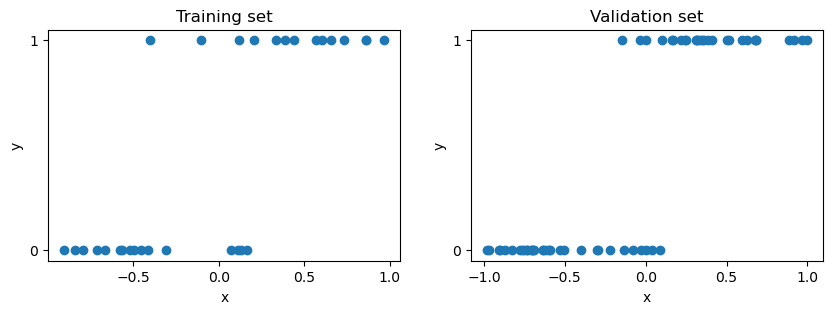

In [5]:
fig, ax = plt.subplots(1,2, figsize = (10,3))
ax[0].set_yticks([0,1]); ax[1].set_yticks([0,1])
ax[0].set_xlabel('x'); ax[1].set_xlabel('x')
ax[0].set_ylabel('y'); ax[1].set_ylabel('y')
ax[0].scatter(X_train.reshape(n_train),y_train.reshape(n_train))
ax[1].scatter(X_valid.reshape(n_valid),y_valid.reshape(n_valid))
ax[0].set_title('Training set'); ax[1].set_title('Validation set') 
plt.show()

## Logistic regression

The logistic regression model is given by 
$$f_{w,b}(x) = \sigma(w x + b), \qquad w, b \in \mathbb{R},$$
where $\sigma$ denotes the sigmoid function (i.e. $f_{w,b}(x)$ is the probability that $y = 1$ given input $x$). 
The corresponding classifier $h_{w,b}: [-1,1] \to \{-1,1\}$ is given by 
$$h_{w,b}(x) =  \begin{cases} 1 & \text{if } wx + b \geq 0 \\
                        0 & \text{otherwise}
          \end{cases}.$$
More complex classifiers can be defined by replacing $wx +b $ with a deep neural network.

The loss function for binary classification is given by 
$$l(w,b;x,y) = \begin{cases} 1 & \text{if } h_{w,b}(x) \neq 0 \\
 0 & \text{otherwise}
\end{cases}.$$

The *risk* for the classifier is defined as the expected value of the loss with respect to the 
$$L(w,b) = \int_{\mathcal{Z}} l(w,b;x,y) d P(x,y).$$
Given a data-set $S = ((x_1,y_1),...,(x_n,y_n)) \sim P^n$, the *empirical risk* is defined as 
$$\hat{L}_S(w,b) = \frac{1}{n} \sum_{i = 1}^n l(w,b;x_i,y_i).$$



To apply gradient descent, we do not use the above loss function, but the binary cross entropy loss (i.e. log loss). 

In [6]:
# Model architecture
class lin(nn.Module):
    def __init__(self):
        super(lin,self).__init__()
        self.lin = nn.Linear(1,1)
    def forward(self,x):
        return self.lin(x)

In [7]:
# Defining linear model
model = lin()
# Printing the randomly initialised parameters of model
for par in model.named_parameters(): 
    print(par)

('lin.weight', Parameter containing:
tensor([[0.2288]], requires_grad=True))
('lin.bias', Parameter containing:
tensor([0.6333], requires_grad=True))


In [8]:
# Training parameters
learning_rate = 0.1
n_epochs = 2000
# Defining loss function and optimiser
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [9]:
# Initiating Pytorch dataloaders
X = torch.tensor(X_train,dtype=torch.float32); y = torch.tensor(y_train,dtype=torch.float32)
dataset = TensorDataset(X,y)
data_train = DataLoader(dataset, batch_size = len(dataset)) # Full batch_size for batch gradient descent
# Training loop
Jtr_hist = []
for t in range(n_epochs):
    Jtr_epoch = 0.0 # Training cost for epoch
    for batch, (X,y) in enumerate(data_train):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Recording loss
        Jtr_epoch += loss.item()
    Jtr_epoch = Jtr_epoch/len(data_train)
    Jtr_hist.append(Jtr_epoch)

In [10]:
# Saving for later use
model_lin_single = model

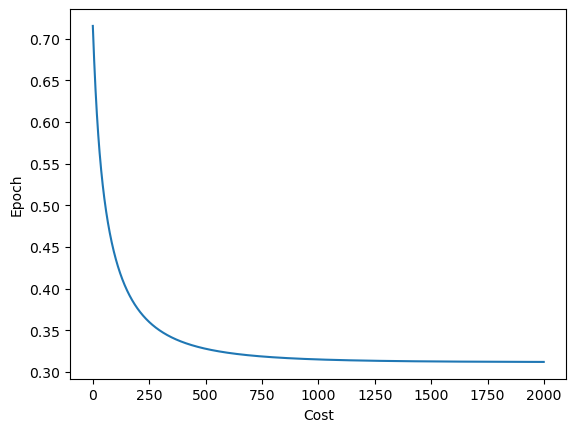

In [11]:
# Plotting training curve
plt.plot(Jtr_hist)
plt.xlabel('Cost')
plt.ylabel('Epoch')
plt.show()

Plotting the trained model:

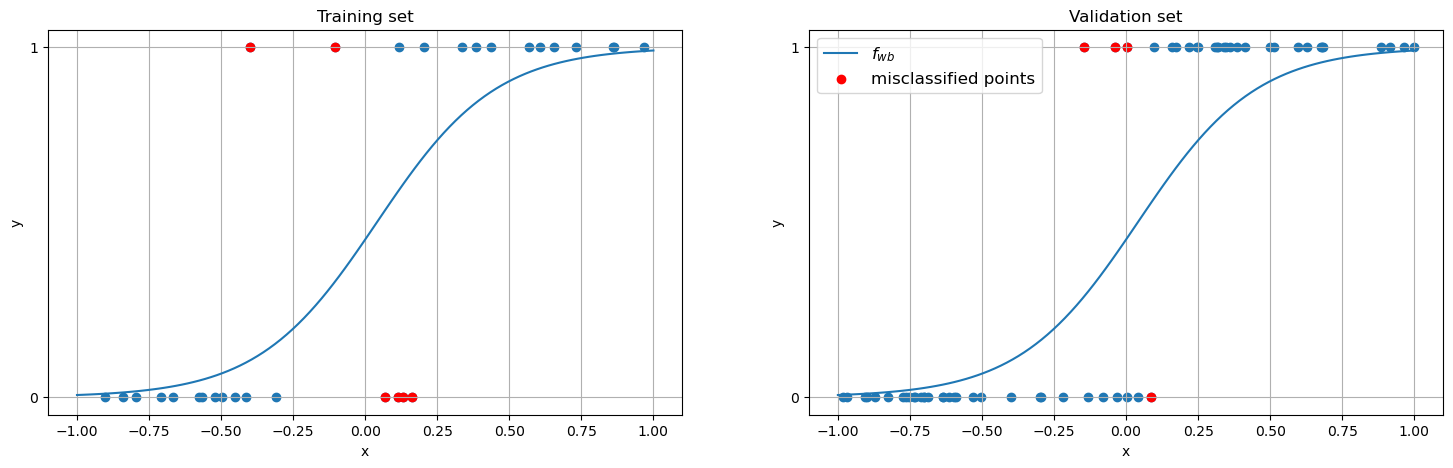

In [12]:
# Computing f_wb(x)
x_arr = np.linspace(-1,1,100)
x_ts = torch.tensor(x_arr, dtype=torch.float32).reshape(len(x_arr),1)
lin_out = model(x_ts)
f_wb =  F.sigmoid(lin_out).detach().numpy().reshape(len(x_arr))
# Computing misclassified points
Xtr_ts = torch.tensor(X_train,dtype = torch.float32); Xval_ts = torch.tensor(X_valid,dtype = torch.float32)
lin_tr = model(Xtr_ts); lin_val = model(Xval_ts) # wx + b
hwb_tr = torch.where(lin_tr >= 0, 1, 0).detach().numpy() # classifier h_wb
hwb_val= torch.where(lin_val >= 0, 1, 0).detach().numpy() 
ytr_flat = y_train.reshape(n_train); yval_flat = y_valid.reshape(n_valid); # Flattening vectors 
x_train = X_train.reshape(n_train); x_valid = X_valid.reshape(n_valid)
misclas_tr = [[x_train[i],ytr_flat[i]] for i in range(n_train) if ytr_flat[i] != hwb_tr[i]] 
misclas_val = [[x_valid[i],yval_flat[i]] for i in range(n_valid) if yval_flat[i] != hwb_val[i]]
misclas_tr = np.array(misclas_tr).transpose(); misclas_val = np.array(misclas_val).transpose()
#Plotting
fig, ax = plt.subplots(1,2,figsize = (18,5))
ax[0].set_yticks([0,1]); ax[1].set_yticks([0,1])
ax[0].set_xlabel('x'); ax[1].set_xlabel('x')
ax[0].set_ylabel('y'); ax[1].set_ylabel('y')
ax[0].plot(x_arr,f_wb); ax[1].plot(x_arr,f_wb, label = r'$f_{wb}$')
ax[0].scatter(X_train.reshape(n_train),y_train.reshape(n_train))
ax[1].scatter(X_valid.reshape(n_valid),y_valid.reshape(n_valid))
if len(misclas_tr) > 0:
    ax[0].scatter(misclas_tr[0],misclas_tr[1],color = 'red')
if len(misclas_val) > 0:
    ax[1].scatter(misclas_val[0],misclas_val[1],color = 'red', label = 'misclassified points')
ax[0].set_title('Training set'); ax[1].set_title('Validation set') 
ax[1].legend(fontsize = 12)
ax[0].grid(), ax[1].grid()
plt.show()

## Probabilistic neural networks

Suppose that the hypothesis set (i.e. the set of possible models), is parameterised by $\mathcal{W} \subset \mathbb{R}^p$.

In the above simple example, $\mathcal{W} = \mathbb{R}^2$ since the only parameters are $w$ and $b$. 
In the case of neural networks, $\mathcal{W}$ shall denote the space of possible weights and biases. 

A *probabilistic neural network* $Q$ is a probability distribution over $\mathcal{W}$.


We shall only consider Gaussian probabilistic neural networks $Q = \mathcal{N}(\mu,s)$, where $\mu \in \mathcal{W}$ and where the covariance matrix $s$ is diagonal.

We parameterise the non-zero elements of $s$ as
$$s = - \log(\sigma(t)), \qquad t \in \mathbb{R}. $$

In [13]:
class Prob_LinModel(nn.Module):
    def __init__(self, s_0=0.1):
        super(Prob_LinModel,self).__init__()
        # Initial s.d. for all weights
        self.s_0 = torch.tensor(s_0,dtype = torch.float32) 
        self.t_0 = torch.special.logit(torch.exp(-self.s_0))
        
        self.mu = nn.Linear(1,1) # For mu parameters
        self.t = copy.deepcopy(self.mu) # For t parameters    
        torch.nn.init.constant_(self.t.weight,self.t_0)
        torch.nn.init.constant_(self.t.bias,self.t_0)
        

    def mean_std(self,x,M=100):
        '''
        Computes empirical approximation with M sampe 
        of the mean and std of inference
        '''
        y_ensemble = torch.unsqueeze(model.forward(x),dim=0)
        for _ in range(M):
            y_new = torch.unsqueeze(model.forward(x),dim=0)
            y_ensemble = torch.cat((y_ensemble,y_new),dim=0)
        mean = torch.mean(y_ensemble,dim = 0)
        std = torch.std(y_ensemble,dim = 0)
        return mean, std
        
    def forward(self,x): 
        e_weight = torch.normal(0, 1, size=model.mu.weight.shape)
        e_bias = torch.normal(0, 1, size=model.mu.bias.shape)
        s_weight = - torch.log(F.sigmoid(self.t.weight))
        s_bias = - torch.log(F.sigmoid(self.t.bias))
        weight = self.mu.weight + s_weight * e_weight
        bias = self.mu.bias + s_bias * e_bias
        return F.linear(x,weight,bias)

In [14]:
# Initiating probabilistic model
model = Prob_LinModel(s_0 = 0.5)

In [15]:
# Setting center of Gaussian to be the previously trained model
model.mu.load_state_dict(model_lin_single.lin.state_dict())

<All keys matched successfully>

In [16]:
# Saving model for later
model_lin_ensemble = model

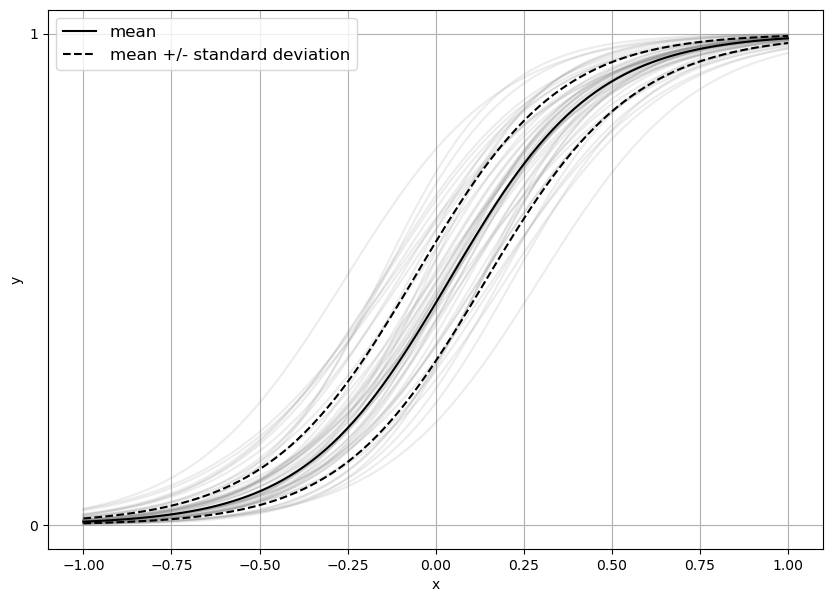

In [17]:
# Plotting a representation of the probabilistic model
fig, ax = plt.subplots(1,1,figsize = (10,7))
ax.set_yticks([0,1])
ax.set_xlabel('x'); ax.set_ylabel('y')

x_ts = torch.linspace(-1,1,100)
x_ts = x_ts.reshape(len(x_ts),1)
num_samples = 50
for _ in range(num_samples):
    y_ts = model(x_ts)
    y_arr = F.sigmoid(y_ts).reshape(len(y_ts)).detach().numpy()
    plt.plot(x_arr,y_arr, color = 'grey', alpha = 0.15)
    y_ts = model(x_ts)
mean_ts, std_ts  = model.mean_std(x_ts, M = 2000)   
mean_arr = F.sigmoid(mean_ts).reshape(len(mean_ts)).detach().numpy()
std_arr_plus = F.sigmoid(mean_ts+std_ts).reshape(len(mean_ts)).detach().numpy()
std_arr_min = F.sigmoid(mean_ts-std_ts).reshape(len(mean_ts)).detach().numpy()
plt.plot(x_arr,mean_arr, color = 'black', label = 'mean')
plt.plot(x_arr,std_arr_plus, color = 'black', label = 'mean +/- standard deviation', linestyle = '--')
plt.plot(x_arr,std_arr_min, color = 'black', linestyle = '--')
ax.legend(fontsize = 12)
ax.grid()
plt.show()

## PAC-Bayes bounds

#### Risk for probabilistic neural networks

The risk for a probabilistic neural network is defined as the expected value of the risk  $L(\omega)$ for $ \omega\sim Q$, 
$$L(Q) := \int_\mathcal{Z} L(\omega) dQ(\omega). $$
The empirical risk for $Q$ is defined similarly
$$ \hat{L}_S(Q) := \int_\mathcal{Z} \hat{L}_S(\omega) dQ(\omega). $$

#### KL divergence

Recall that the KL-divergence measures the distance between two probability distributions. 
Given probability distributions $Q$ and $Q_0$, we denote the $KL$-divergence by
$KL(Q\|Q_0)$.

If $Q$ and $Q_0$ are scaler Gaussian distributions, 
$$Q = \mathcal{N}(\mu,s) \qquad \text{and}  \qquad Q_0 = \mathcal{N}(\mu_0,s_0),$$
then the KL divergence may be explicitly calculated as
$$KL(Q\|Q_0) = \frac{1}{2} \left( \log \left( \frac{s_0}{s}\right) + \frac{(\mu - \mu_0)^2}{s_0} + \frac{s}{s_0} - 1 \right).$$
To obtain, the KL divergence between multi-variate Gaussian distributions with diagonal covariance matrices, we simply sum the KL divergences between the components.



#### PAC-Bayes bounds

The following PAC-Bayes bound gives a rigorous, computable error bound for the true risk of a probabilistic neural network, even through the data-generating distribution $P$ is unknown. We assume that the range of the loss function $l$ is contained in $[0,1]$.

**Theorem** Fix a probability distribution $Q_0 = \mathcal{N}(\mu_0,s_0)$ over $\mathcal{W}$ (i.e. the prior). Then,for any $\delta > 0$ and $\delta' > 0$, we have 
$$L(Q) \leq \frac{1}{m}\sum_{j=1}^m \hat{L}_S(\omega_j) + \sqrt{\frac{\log\left(\frac{2}{\delta'}\right)}{m}} + \sqrt{\frac{KL(Q\|Q_0) + \log\left(\frac{2 \sqrt{n}}{\delta}\right)}{n}} $$
with at least probability $1 - \delta - \delta'$ over i.i.d. samples $S = ((x_1,y_1),...,(x_n,y_n)) \sim P^n$ and $(\omega_1,...,\omega_m) \sim Q^m$.

#### Trained priors

In order to reduce the size of the rhs of the the PAC-Bayes bound, one may train the prior $Q_0$, *provided the data we use for the training is independent of the data $S$ used to evaluate the PAC-Bayes bound*. 

Precisely, what we mean by training $Q_0$ is training a model in the standard way (i.e. empirical risk minimisation) to obtain a set of parameters $\mu_0 \in \mathcal{W}_0$, then setting $s_0$ by hand.

In [18]:
# We take the prior to be the previously trained (with X_train) network with s_0 = 0.5 I
prior = model_lin_ensemble

#### Setting posterior manually

Now let's train another model that will act as $\mu$ for the posterior $Q$.
We will set the standard deviation $s$ for $Q$ by hand and experiment with different values.

To train $\mu$ we use *both* the training and validation set. This is a perfectly valid thing to do since probabilistic neural networks with PAC-Bayes are examples of "self-certified models". (Note however that it is good practice to always validate the end model with an out-of-sample test-set)

In [19]:
# Defining linear model
model = lin()
# Training parameters
learning_rate = 0.05
n_epochs = 4000
# Defining loss function and optimiser
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [20]:
# Initiating Pytorch dataloaders
X = torch.tensor(X_full,dtype=torch.float32); y = torch.tensor(y_full,dtype=torch.float32)
dataset = TensorDataset(X,y)
data_train = DataLoader(dataset, batch_size = len(dataset)) # Full batch_size for batch gradient descent
# Training loop
Jtr_hist = []
for t in range(n_epochs):
    Jtr_epoch = 0.0 # Training cost for epoch
    for batch, (X,y) in enumerate(data_train):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Recording loss
        Jtr_epoch += loss.item()
    Jtr_epoch = Jtr_epoch/len(data_train)
    Jtr_hist.append(Jtr_epoch)

In [21]:
# Saving for later use
post_lin_single = model

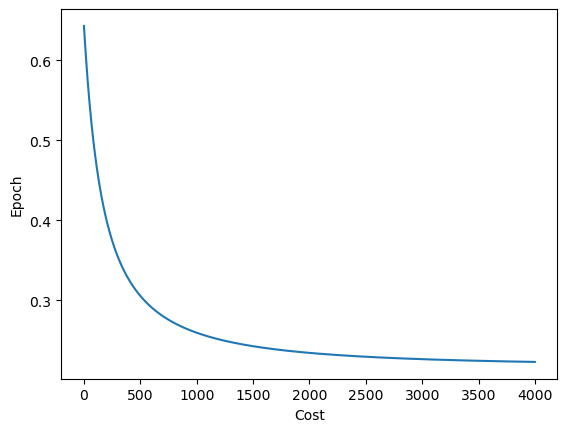

In [22]:
# Plotting training curve
plt.plot(Jtr_hist)
plt.xlabel('Cost'); plt.ylabel('Epoch')
plt.show()

First, we set $s = 0.1 I$.

In [23]:
# Initiating probabilistic model
posterior = Prob_LinModel(s_0 = 0.1)
# Setting center of Gaussian to be the previously trained model
posterior.mu.load_state_dict(post_lin_single.lin.state_dict())

<All keys matched successfully>

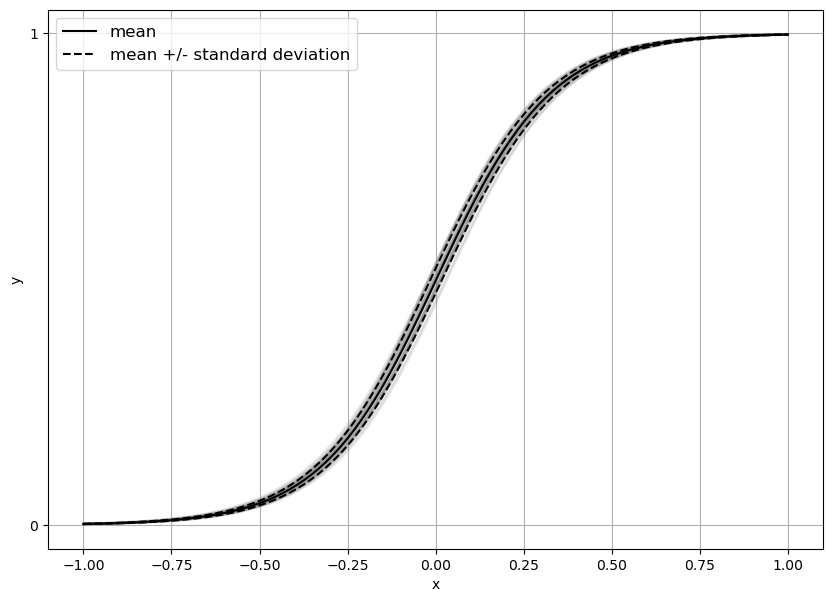

In [24]:
# Plotting a representation of the probabilistic model
model = posterior
fig, ax = plt.subplots(1,1,figsize = (10,7))
ax.set_yticks([0,1])
ax.set_xlabel('x'); ax.set_ylabel('y')

x_ts = torch.linspace(-1,1,100)
x_ts = x_ts.reshape(len(x_ts),1)
num_samples = 50
for _ in range(num_samples):
    y_ts = model(x_ts)
    y_arr = F.sigmoid(y_ts).reshape(len(y_ts)).detach().numpy()
    plt.plot(x_arr,y_arr, color = 'grey', alpha = 0.15)
    y_ts = model(x_ts)
mean_ts, std_ts  = model.mean_std(x_ts, M = 2000)   
mean_arr = F.sigmoid(mean_ts).reshape(len(mean_ts)).detach().numpy()
std_arr_plus = F.sigmoid(mean_ts+std_ts).reshape(len(mean_ts)).detach().numpy()
std_arr_min = F.sigmoid(mean_ts-std_ts).reshape(len(mean_ts)).detach().numpy()
plt.plot(x_arr,mean_arr, color = 'black', label = 'mean')
plt.plot(x_arr,std_arr_plus, color = 'black', label = 'mean +/- standard deviation', linestyle = '--')
plt.plot(x_arr,std_arr_min, color = 'black', linestyle = '--')
ax.legend(fontsize = 12)
ax.grid()
plt.show()

In [25]:
def KL_gauss(prior,posterior):
    mu_par = posterior.mu.state_dict()
    mu0_par = prior.mu.state_dict()
    t_par = posterior.t.state_dict()
    t0_par = prior.t.state_dict()
    KL = 0
    # Loop over parameters sets (weight matrices or bias matrices) of all layers
    for mu, mu_0, t, t_0 in zip(mu_par.values(), mu0_par.values(), t_par.values(), t0_par.values()):
        s = - torch.log(F.sigmoid(t))
        s_0 = - torch.log(F.sigmoid(t_0))
        KL_batch = 0.5*(torch.log(s_0/s) + (mu - mu_0)**2/s_0 + s/s_0 - 1) # KL divergence of parameter set 
        KL += KL_batch.sum()
    return KL

def term_3(prior, posterior, delta, n):
    KL = KL_gauss(prior,posterior)
    return torch.sqrt((KL + log(2*sqrt(n)/delta))/n)

def term_2(deltap, m):
    return sqrt(log(2/deltap)/m)

def emp_error(posterior, m, X, y):
    '''
    Average misclassification error for m samples of posterior
    '''
    acc = 0
    for _ in range(m):
        yhat = torch.where(posterior(X) >= 0 , 1, 0)
        accuracy = Accuracy(task="binary")
        acc += accuracy(yhat, y)
    acc = acc / m
    mis_err = 1 - acc
    return mis_err

def give_PAC_Bayes_error(prior, posterior, m, n, delta, deltap, X, y):
    return emp_error(posterior, m, X, y) + term_2(deltap, m) + term_3(prior, posterior, delta, n)

In [26]:
delta = 0.05; deltap = 0.001;
m = 1000; n = n_valid;
X = torch.tensor(X_valid,dtype=torch.float32); y = torch.tensor(y_valid,dtype=torch.float32)

PB_err = give_PAC_Bayes_error(prior, posterior, m, n, delta, deltap, X, y)
emp_err = emp_error(posterior, m, X, y)
print('Empirical misclassification error: ', emp_err.item(), '\nPAC-Bayes error: ',  PB_err.item())

Empirical misclassification error:  0.08345997333526611 
PAC-Bayes error:  0.5392749309539795


When we increase the number of points in the validation set, the PAC-Bayes bound decreases.

In [27]:
n_valid_2 = 50000000 # Number of points in the validation set
s = 0.2 # Dataset noise
X_valid_2, y_valid_2 = give_data(n_valid, s)

In [28]:
delta = 0.001; deltap = 0.05;
m = 22200; n = n_valid_2;
X = torch.tensor(X_valid_2,dtype=torch.float32); y = torch.tensor(y_valid_2,dtype=torch.float32)

PB_err = give_PAC_Bayes_error(prior, posterior, m, n, delta, deltap, X, y)
emp_err = emp_error(posterior, m, X, y)
print(f'Empirical misclassification error ({n_valid_2} points): ', emp_err.item(), f'\nPAC-Bayes error ({n_valid_2} points): ',  PB_err.item())

Empirical misclassification error (50000000 points):  0.08652395009994507 
PAC-Bayes error (50000000 points):  0.10002437233924866


Next, we plot the empirical misclassification error and PAC-Bayes error for a range of values of $s$, 
the standard deviation for the posterior.

In [29]:
delta = 0.05; deltap = 0.001;
m = 100; n = n_valid;
X = torch.tensor(X_valid,dtype=torch.float32); y = torch.tensor(y_valid,dtype=torch.float32)
s_arr = np.linspace(0.01,1,100)
emp_lst = []
PB_lst = [] 
for s in s_arr:
    # Initiating probabilistic model
    posterior = Prob_LinModel(s_0 = s )
    # Setting center of Gaussian to be the previously trained model
    posterior.mu.load_state_dict(post_lin_single.lin.state_dict())
    emp_lst.append(emp_error(posterior,m, X, y).item())
    PB_lst.append(give_PAC_Bayes_error(prior, posterior, m, n, delta, deltap, X, y).item())

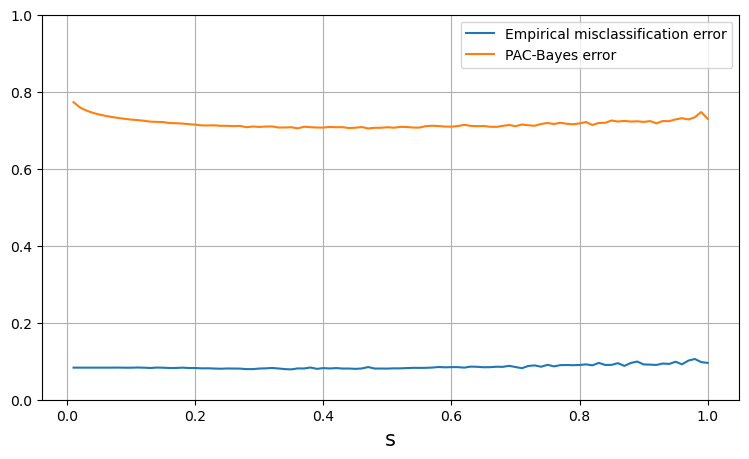

In [30]:
fig, ax = plt.subplots(1,1,figsize= (9,5))
ax.plot(s_arr, emp_lst, label = 'Empirical misclassification error')
ax.plot(s_arr, PB_lst, label = 'PAC-Bayes error')
ax.set_ylim([0,1]); ax.set_xlabel('s',fontsize = 15)
ax.grid()
ax.legend()
plt.show()

## PAC-Bayes with backprop

We train a probabilistic neural network $Q = \mathcal{N}(\mu;s)$ by gradient descent with the following procedure. 
1. Sample `m` noise tensors $(e_1,...,e_m) \sim \mathcal{N}(0;1)^m$, which each match the shape of the parameters of the NN architecture. 
2. Compute 
$$\omega_j = \mu + e_j *( - \log(\sigma(t))), \qquad j = 1,...,m,$$
where $*$ denotes element-wise multiplication. Then, $\omega_j \sim \mathcal{N}(\mu;s)$ for each $j$. 
3. Compute the approximation of the empirical loss for the probabilistic neural network, 
$$\mathcal{L}_{m}(\mu,t) := \frac{1}{m} \sum_{j=1}^m \tilde{l}_S(\omega_j)$$
where $\tilde l$ is the cross-entropy loss and $S$ the mini-batch. 
4. Take the gradient of $\mathcal{L}_m$ with respect to $\mu$ and $t$. 
5. Update $\mu$ and $t$ accordingly.

In [31]:
def av_loss(model, m, X, y):
    loss_fn = nn.BCEWithLogitsLoss()
    loss = 0
    for _ in range(m):
        pred = model(X)
        loss += loss_fn(pred, y)
    return loss / m

In [32]:
class Prob_LinModel(nn.Module):
    def __init__(self, s_0=0.1):
        super(Prob_LinModel,self).__init__()
        # Initial s.d. for all weights
        self.s_0 = torch.tensor(s_0,dtype = torch.float32) 
        self.t_0 = torch.special.logit(torch.exp(-self.s_0))
        
        self.mu = nn.Linear(1,1) # For mu parameters
        self.t = copy.deepcopy(self.mu) # For t parameters    
        torch.nn.init.constant_(self.t.weight,self.t_0)
        torch.nn.init.constant_(self.t.bias,self.t_0)
        

    def mean_std(self,x,M=100):
        '''
        Computes empirical approximation with M sampe 
        of the mean and std of inference
        '''
        y_ensemble = torch.unsqueeze(model.forward(x),dim=0)
        for _ in range(M):
            y_new = torch.unsqueeze(model.forward(x),dim=0)
            y_ensemble = torch.cat((y_ensemble,y_new),dim=0)
        mean = torch.mean(y_ensemble,dim = 0)
        std = torch.std(y_ensemble,dim = 0)
        return mean, std
        
    def forward(self,x): 
        e_weight = torch.normal(0, 1, size=model.mu.weight.shape)
        e_bias = torch.normal(0, 1, size=model.mu.bias.shape)
        s_weight = - torch.log(F.sigmoid(self.t.weight))
        s_bias = - torch.log(F.sigmoid(self.t.bias))
        weight = self.mu.weight + s_weight * e_weight
        bias = self.mu.bias + s_bias * e_bias
        return F.linear(x,weight,bias)

In [33]:
# Initiating model as the prior
model = Prob_LinModel(s_0 = 0.5 )
model.mu.load_state_dict(prior.mu.state_dict())

<All keys matched successfully>

In [34]:
# Training parameters
learning_rate = 0.3
n_epochs = 400
# Defining loss function and optimiser
optimizer_mu = torch.optim.SGD(model.mu.parameters(), lr=learning_rate)
optimizer_t = torch.optim.SGD(model.t.parameters(), lr=learning_rate)

In [35]:
# Initiating Pytorch dataloaders
X_ts = torch.tensor(X_full,dtype=torch.float32); y_ts = torch.tensor(y_full,dtype=torch.float32)
dataset = TensorDataset(X_ts,y_ts)
data_train = DataLoader(dataset, batch_size = len(dataset)) # Full batch_size for batch gradient descent
# Number of samples of model distribution per training step
m = 100
# Training loop
Jtr_hist = []
for t in range(n_epochs):
    Jtr_epoch = 0.0 # Training cost for epoch
    for batch, (X,y) in enumerate(data_train):
        # Compute prediction and loss
        loss = av_loss(model, m, X, y)
        # Backpropagation
        optimizer_mu.zero_grad(); optimizer_t.zero_grad()
        loss.backward()
        optimizer_mu.step(); optimizer_t.step()
        # Recording loss
        Jtr_epoch += loss.item()
    Jtr_epoch = Jtr_epoch/len(data_train)
    Jtr_hist.append(Jtr_epoch)

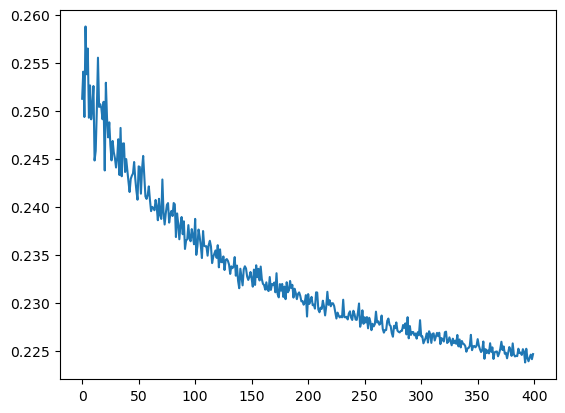

In [36]:
plt.plot(Jtr_hist)

Note that the training curve may look different to usual since we initialised with a training prior, which was already close to the minima.

In [37]:
model_backprop1 = model

In [38]:
delta = 0.001; deltap = 0.05;
m = 100; n = n_valid;
X = torch.tensor(X_valid,dtype=torch.float32); y = torch.tensor(y_valid,dtype=torch.float32)

PB_err = give_PAC_Bayes_error(prior, posterior, m, n, delta, deltap, X, y)
emp_err = emp_error(posterior, m, X, y)
print('Empirical misclassification error: ', emp_err.item(), '\nPAC-Bayes error: ',  PB_err.item())

Empirical misclassification error:  0.09766656160354614 
PAC-Bayes error:  0.7312362194061279


In [39]:
print('Weight s.d.: ', -torch.log(torch.sigmoid(model.t.weight.reshape(()))))
print('Bias s.d.: ', -torch.log(torch.sigmoid(model.t.bias.reshape(()))))

Weight s.d.:  tensor(0.4308, grad_fn=<NegBackward0>)
Bias s.d.:  tensor(0.2270, grad_fn=<NegBackward0>)


Plotting the trained probabilistic model:

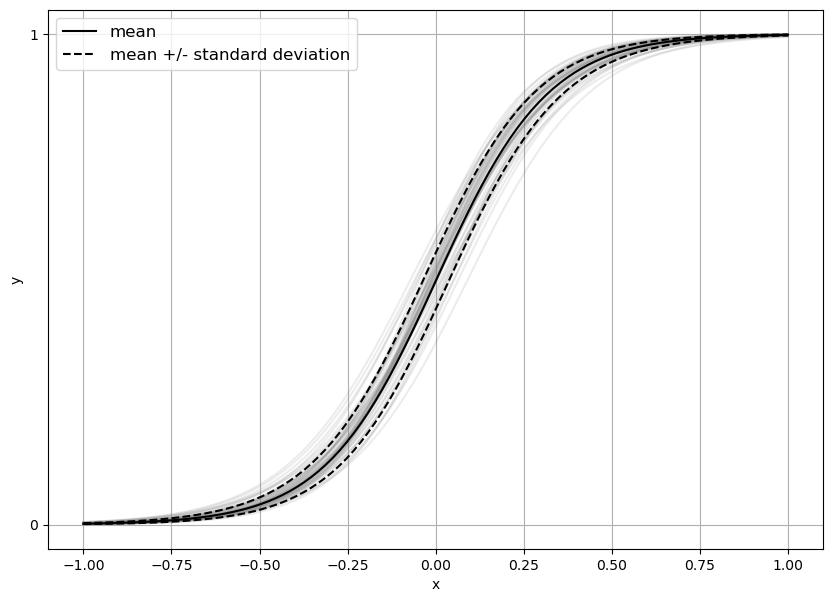

In [40]:
# Plotting a representation of the probabilistic model
fig, ax = plt.subplots(1,1,figsize = (10,7))
ax.set_yticks([0,1])
ax.set_xlabel('x'); ax.set_ylabel('y')

x_ts = torch.linspace(-1,1,100)
x_ts = x_ts.reshape(len(x_ts),1)
num_samples = 50
for _ in range(num_samples):
    y_ts = model(x_ts)
    y_arr = F.sigmoid(y_ts).reshape(len(y_ts)).detach().numpy()
    plt.plot(x_arr,y_arr, color = 'grey', alpha = 0.15)
    y_ts = model(x_ts)
mean_ts, std_ts  = model.mean_std(x_ts, M = 2000)   
mean_arr = F.sigmoid(mean_ts).reshape(len(mean_ts)).detach().numpy()
std_arr_plus = F.sigmoid(mean_ts+std_ts).reshape(len(mean_ts)).detach().numpy()
std_arr_min = F.sigmoid(mean_ts-std_ts).reshape(len(mean_ts)).detach().numpy()
plt.plot(x_arr,mean_arr, color = 'black', label = 'mean')
plt.plot(x_arr,std_arr_plus, color = 'black', label = 'mean +/- standard deviation', linestyle = '--')
plt.plot(x_arr,std_arr_min, color = 'black', linestyle = '--')
ax.legend(fontsize = 12)
ax.grid()
plt.show()

#### Training to minimise full PAC-Bayes error

Next, we experiment with applying gradient descent to a probabilistic neural network in a different way, using the full right hand side of the PAC-Bayes bound as an objective function.

In [41]:
def PAC_loss(model, m, X, y,prior, delta, n,lam):
    loss_fn = nn.BCEWithLogitsLoss()
    loss = 0
    for _ in range(m):
        pred = model(X)
        loss += loss_fn(pred, y)
    return loss / m + lam*term_3(prior, model, delta, n)

In [42]:
# Initiating model as the prior
model = Prob_LinModel(s_0 = 1 )
model.mu.load_state_dict(prior.mu.state_dict())

<All keys matched successfully>

In [43]:
delta = 0.001
# Training parameters
learning_rate = 0.2
n_epochs = 2000
# Defining loss function and optimiser
optimizer_mu = torch.optim.SGD(model.mu.parameters(), lr=learning_rate)
optimizer_t = torch.optim.SGD(model.t.parameters(), lr=learning_rate)

In [44]:
# Initiating Pytorch dataloaders
X_ts = torch.tensor(X_full,dtype=torch.float32); y_ts = torch.tensor(y_full,dtype=torch.float32)
dataset = TensorDataset(X_ts,y_ts)
data_train = DataLoader(dataset, batch_size = len(dataset)) # Full batch_size for batch gradient descent
# Number of samples of model distribution per training step
m = 100
# Scaling constant for PAC-Bayes term
lam = 0.1
# Training loop
Jtr_hist = []
for t in range(n_epochs):
    Jtr_epoch = 0.0 # Training cost for epoch
    for batch, (X,y) in enumerate(data_train):
        # Compute prediction and loss
        loss = PAC_loss(model, m, X, y,prior, delta, len(X),lam)
        # Backpropagation
        optimizer_mu.zero_grad(); optimizer_t.zero_grad()
        loss.backward()
        optimizer_mu.step(); optimizer_t.step()
        # Recording loss
        Jtr_epoch += loss.item()
    Jtr_epoch = Jtr_epoch/len(data_train)
    Jtr_hist.append(Jtr_epoch)

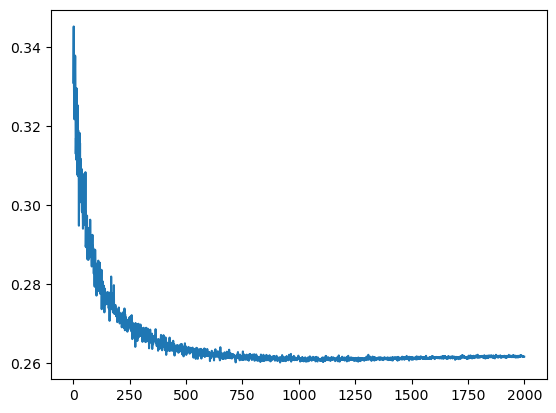

In [45]:
plt.plot(Jtr_hist)

Note that the training curve may look different to usual since we initialised with a training prior, which was already close to the minima.

In [46]:
model_backprop2 = model

In [47]:
delta = 0.001; deltap = 0.05;
m = 100; n = n_valid;
X = torch.tensor(X_valid,dtype=torch.float32); y = torch.tensor(y_valid,dtype=torch.float32)

PB_err = give_PAC_Bayes_error(prior, posterior, m, n, delta, deltap, X, y)
emp_err = emp_error(posterior, m, X, y)
print('Empirical misclassification error: ', emp_err.item(), '\nPAC-Bayes error: ',  PB_err.item())

Empirical misclassification error:  0.10416650772094727 
PAC-Bayes error:  0.7269030809402466


In [48]:
print('Weight s.d.: ', -torch.log(torch.sigmoid(model.t.weight.reshape(()))))
print('Bias s.d.: ', -torch.log(torch.sigmoid(model.t.bias.reshape(()))))

Weight s.d.:  tensor(0.5255, grad_fn=<NegBackward0>)
Bias s.d.:  tensor(0.1428, grad_fn=<NegBackward0>)


Plotting the trained probabilistic model:

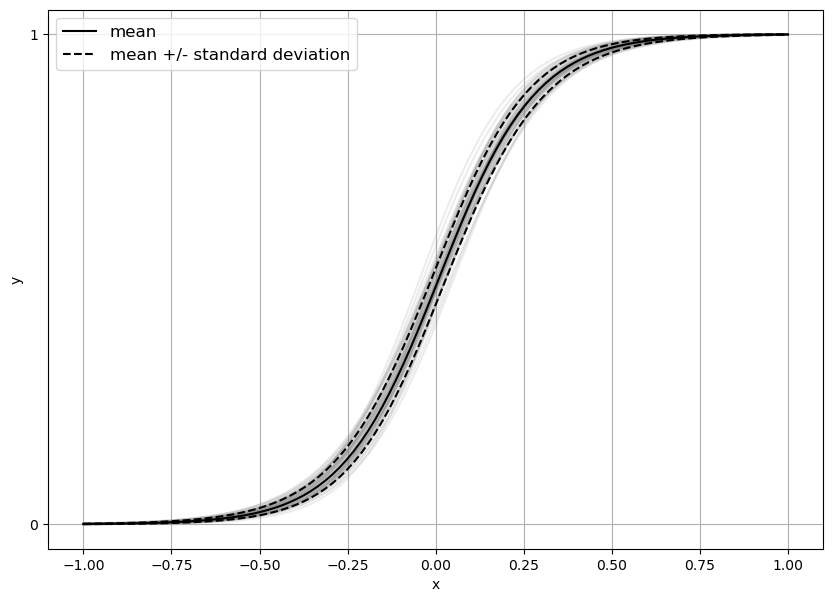

In [49]:
# Plotting a representation of the probabilistic model
fig, ax = plt.subplots(1,1,figsize = (10,7))
ax.set_yticks([0,1])
ax.set_xlabel('x'); ax.set_ylabel('y')

x_ts = torch.linspace(-1,1,100)
x_ts = x_ts.reshape(len(x_ts),1)
num_samples = 50
for _ in range(num_samples):
    y_ts = model(x_ts)
    y_arr = F.sigmoid(y_ts).reshape(len(y_ts)).detach().numpy()
    plt.plot(x_arr,y_arr, color = 'grey', alpha = 0.15)
    y_ts = model(x_ts)
mean_ts, std_ts  = model.mean_std(x_ts, M = 2000)   
mean_arr = F.sigmoid(mean_ts).reshape(len(mean_ts)).detach().numpy()
std_arr_plus = F.sigmoid(mean_ts+std_ts).reshape(len(mean_ts)).detach().numpy()
std_arr_min = F.sigmoid(mean_ts-std_ts).reshape(len(mean_ts)).detach().numpy()
plt.plot(x_arr,mean_arr, color = 'black', label = 'mean')
plt.plot(x_arr,std_arr_plus, color = 'black', label = 'mean +/- standard deviation', linestyle = '--')
plt.plot(x_arr,std_arr_min, color = 'black', linestyle = '--')
ax.legend(fontsize = 12)
ax.grid()
plt.show()

## Adding a hidden layer: can a probabilistic neural network self-regularise an over-fitting prior?

In this final section, we add two hidden layers with `M` neurons to the underlying neural network architecture. 

We shall over-fit the prior by setting `M` quite large and training without regularisation on (`X_train`,`y_train`). 
We shall then train a probabilistic neural network on (`X_full`,`y_full`) initialised as the center of the prior. 
Does the trained probabilistic model still overfit the data?

**Answer: Yes!**


In [50]:
print('len(X_train):',len(X_train))
print('len(X_valid):',len(X_valid))
print('len(X_full):',len(X_full))

len(X_train): 30
len(X_valid): 60
len(X_full): 90


#### Overfitting the prior

In [51]:
# Defining model with one hidden layer
M = 1000
class NN(nn.Module):
    def __init__(self, M = 1000):
        super(NN,self).__init__()
        self.lin1 = nn.Linear(1,M)
        self.lin2 = nn.Linear(M,M)
        self.lin3 = nn.Linear(M,1)
    
    def forward(self, x):
        z1 = self.lin1(x)
        a1 = torch.relu(z1)
        z2 = self.lin2(a1)
        a2 = torch.relu(z2)
        return self.lin3(a2)
    
model = NN(M = M)

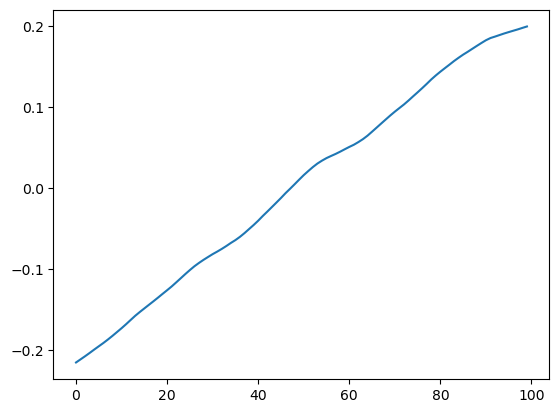

In [52]:
x_ts = torch.linspace(-1,1,100).reshape(100,1)
plt.plot(model(x_ts).detach().numpy())

In [53]:
# Training parameters
learning_rate = 0.07
n_epochs = 2000
# Defining loss function and optimiser
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())

In [54]:
# Initiating Pytorch dataloaders
X = torch.tensor(X_train,dtype=torch.float32); y = torch.tensor(y_train,dtype=torch.float32)
dataset = TensorDataset(X,y)
data_train = DataLoader(dataset, batch_size = 20) # Full batch_size for batch gradient descent
# Training loop
Jtr_hist = []
for t in range(n_epochs):
    Jtr_epoch = 0.0 # Training cost for epoch
    for batch, (X,y) in enumerate(data_train):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Recording loss
        Jtr_epoch += loss.item()
    Jtr_epoch = Jtr_epoch/len(data_train)
    Jtr_hist.append(Jtr_epoch)

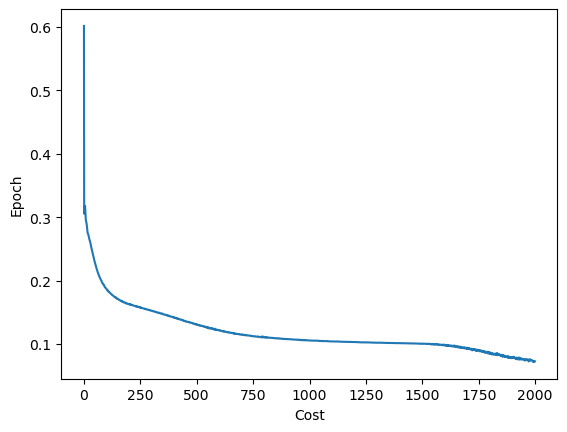

In [55]:
# Plotting training curve
plt.plot(Jtr_hist)
plt.xlabel('Cost')
plt.ylabel('Epoch')
plt.show()

In [56]:
# Saving for later use
prior_nn_mu = model

Plotting the trained model:

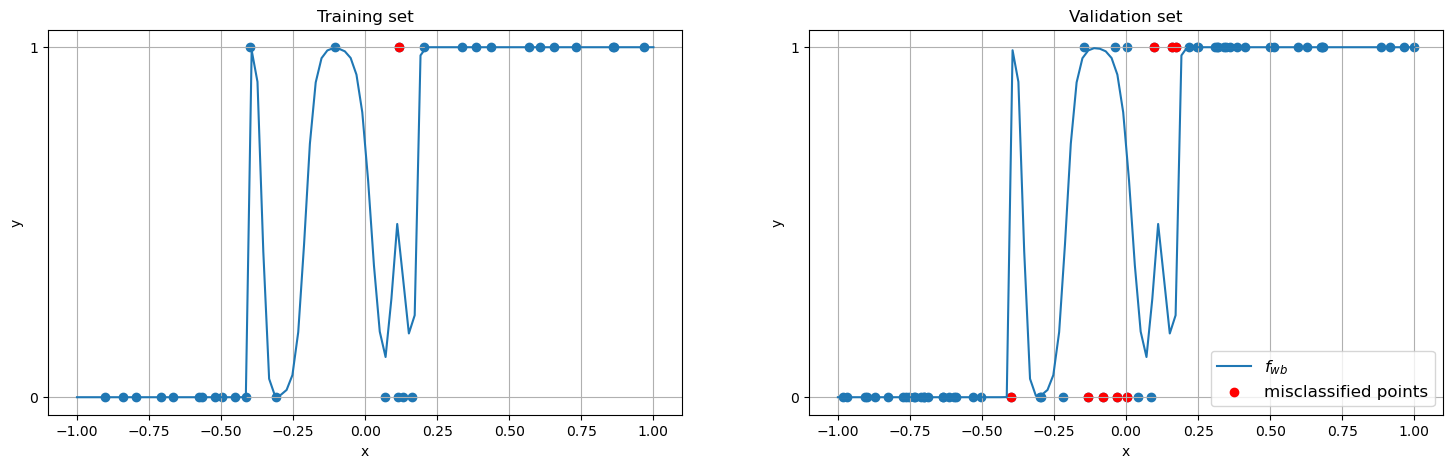

In [57]:
# Computing f_wb(x)
x_arr = np.linspace(-1,1,100)
x_ts = torch.tensor(x_arr, dtype=torch.float32).reshape(len(x_arr),1)
lin_out = model(x_ts)
f_wb =  F.sigmoid(lin_out).detach().numpy().reshape(len(x_arr))
# Computing misclassified points
Xtr_ts = torch.tensor(X_train,dtype = torch.float32); Xval_ts = torch.tensor(X_valid,dtype = torch.float32)
lin_tr = model(Xtr_ts); lin_val = model(Xval_ts) # wx + b
hwb_tr = torch.where(lin_tr >= 0, 1, 0).detach().numpy() # classifier h_wb
hwb_val= torch.where(lin_val >= 0, 1, 0).detach().numpy() 
ytr_flat = y_train.reshape(n_train); yval_flat = y_valid.reshape(n_valid); # Flattening vectors 
x_train = X_train.reshape(n_train); x_valid = X_valid.reshape(n_valid)
misclas_tr = [[x_train[i],ytr_flat[i]] for i in range(n_train) if ytr_flat[i] != hwb_tr[i]] 
misclas_val = [[x_valid[i],yval_flat[i]] for i in range(n_valid) if yval_flat[i] != hwb_val[i]]
misclas_tr = np.array(misclas_tr).transpose(); misclas_val = np.array(misclas_val).transpose()
#Plotting
fig, ax = plt.subplots(1,2,figsize = (18,5))
ax[0].set_yticks([0,1]); ax[1].set_yticks([0,1])
ax[0].set_xlabel('x'); ax[1].set_xlabel('x')
ax[0].set_ylabel('y'); ax[1].set_ylabel('y')
ax[0].plot(x_arr,f_wb); ax[1].plot(x_arr,f_wb, label = r'$f_{wb}$')
ax[0].scatter(X_train.reshape(n_train),y_train.reshape(n_train))
ax[1].scatter(X_valid.reshape(n_valid),y_valid.reshape(n_valid))
if len(misclas_tr) > 0:
    ax[0].scatter(misclas_tr[0],misclas_tr[1],color = 'red')
if len(misclas_val) > 0:
    ax[1].scatter(misclas_val[0],misclas_val[1],color = 'red', label = 'misclassified points')
ax[0].set_title('Training set'); ax[1].set_title('Validation set') 
ax[1].legend(fontsize = 12)
ax[0].grid(), ax[1].grid()
plt.show()

Class for probabilistic neural network with two hidden layers, each with `M` neurons:

In [58]:
class Prob_NNModel(nn.Module):
    def __init__(self, s_0=0.1, M = 1000):
        super(Prob_NNModel,self).__init__()
        # Initial s.d. for all weights
        self.s_0 = torch.tensor(s_0,dtype = torch.float32) 
        self.t_0 = torch.special.logit(torch.exp(-self.s_0))
        
        # Layer 1
        self.mu1 = nn.Linear(1,M) # For mu parameters
        self.t1 = copy.deepcopy(self.mu1) # For t parameters    
        torch.nn.init.constant_(self.t1.weight,self.t_0)
        torch.nn.init.constant_(self.t1.bias,self.t_0)
        # Layer 2
        self.mu2 = nn.Linear(M,M) # For mu parameters
        self.t2 = copy.deepcopy(self.mu2) # For t parameters    
        torch.nn.init.constant_(self.t2.weight,self.t_0)
        torch.nn.init.constant_(self.t2.bias,self.t_0)
        #Layer 3
        self.mu3 = nn.Linear(M,1) # For mu parameters
        self.t3 = copy.deepcopy(self.mu3) # For t parameters    
        torch.nn.init.constant_(self.t3.weight,self.t_0)
        torch.nn.init.constant_(self.t3.bias,self.t_0)
        

    def mean_std(self,x,M=100):
        '''
        Computes empirical approximation with M sampe 
        of the mean and std of inference
        '''
        y_ensemble = torch.unsqueeze(model.forward(x),dim=0)
        for _ in range(M):
            y_new = torch.unsqueeze(model.forward(x),dim=0)
            y_ensemble = torch.cat((y_ensemble,y_new),dim=0)
        mean = torch.mean(y_ensemble,dim = 0)
        std = torch.std(y_ensemble,dim = 0)
        return mean, std
        
    def forward(self,x): 
        ## Genberating noise and s vals
        # Layer 1
        e1_weight = torch.normal(0, 1, size=self.mu1.weight.shape)
        e1_bias = torch.normal(0, 1, size=self.mu1.bias.shape)
        s1_weight = - torch.log(F.sigmoid(self.t1.weight))
        s1_bias = - torch.log(F.sigmoid(self.t1.bias))
        # Layer 2
        e2_weight = torch.normal(0, 1, size=self.mu2.weight.shape)
        e2_bias = torch.normal(0, 1, size=self.mu2.bias.shape)
        s2_weight = - torch.log(F.sigmoid(self.t2.weight))
        s2_bias = - torch.log(F.sigmoid(self.t2.bias))
        # Layer 3
        e3_weight = torch.normal(0, 1, size=self.mu3.weight.shape)
        e3_bias = torch.normal(0, 1, size=self.mu3.bias.shape)
        s3_weight = - torch.log(F.sigmoid(self.t3.weight))
        s3_bias = - torch.log(F.sigmoid(self.t3.bias))
        ## Constructing weights and biases
        # Layer 1
        weight1 = self.mu1.weight + s1_weight * e1_weight
        bias1 = self.mu1.bias + s1_bias * e1_bias
        weight2 = self.mu2.weight + s2_weight * e2_weight
        bias2 = self.mu2.bias + s2_bias * e2_bias
        weight3 = self.mu3.weight + s3_weight * e3_weight
        bias3 = self.mu3.bias + s3_bias * e3_bias
        ## Forward prop
        z1 = F.linear(x,weight1,bias1)
        a1 = torch.relu(z1)
        z2 = F.linear(a1,weight2,bias2)
        a2 = torch.relu(z2)
        return F.linear(a2,weight3,bias3)

In [59]:
def av_loss(model, m, X, y):
    loss_fn = nn.BCEWithLogitsLoss()
    loss = 0
    for _ in range(m):
        pred = model(X)
        loss += loss_fn(pred, y)
    return loss / m

In [60]:
# Initiating model as the prior
model = Prob_NNModel(s_0 = 0.5, M = 1000)
model.mu1.load_state_dict(prior_nn_mu.lin1.state_dict())
model.mu2.load_state_dict(prior_nn_mu.lin2.state_dict())
model.mu3.load_state_dict(prior_nn_mu.lin3.state_dict())

<All keys matched successfully>

In [61]:
# Training parameters
learning_rate = 0.3
n_epochs = 20
# Defining loss function and optimiser
params = list(model.mu1.parameters()) + list(model.t1.parameters()) + list(model.mu2.parameters()) + list(model.t2.parameters()) + list(model.mu3.parameters()) + list(model.t3.parameters())
optimizer = torch.optim.SGD(params, lr=learning_rate)

In [62]:
# Initiating Pytorch dataloaders
X_ts = torch.tensor(X_full,dtype=torch.float32); y_ts = torch.tensor(y_full,dtype=torch.float32)
dataset = TensorDataset(X_ts,y_ts)
data_train = DataLoader(dataset, batch_size = len(dataset)) # Full batch_size for batch gradient descent
# Number of samples of model distribution per training step
m = 100
# Training loop
Jtr_hist = []
for t in range(n_epochs):
    Jtr_epoch = 0.0 # Training cost for epoch
    for batch, (X,y) in enumerate(data_train):
        # Compute prediction and loss
        loss = av_loss(model, m, X, y)
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Recording loss
        Jtr_epoch += loss.item()
    Jtr_epoch = Jtr_epoch/len(data_train)
    Jtr_hist.append(Jtr_epoch)

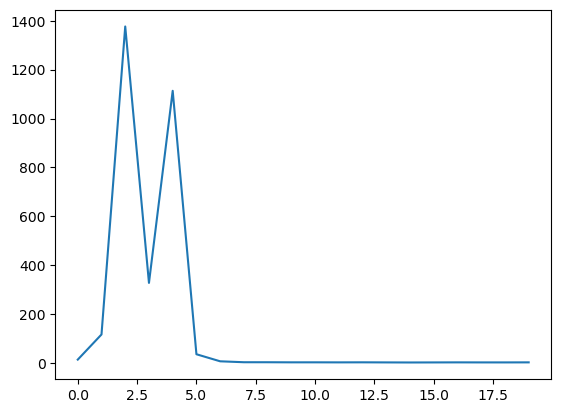

In [63]:
plt.plot(Jtr_hist)

In [64]:
model_probnn1 = model

Next, we plot `mu` (i.e. center of the Gaussian) for the trained probabilistic NN. 

Note that the `mu` was initialised as the prior and severely overfit the training data.

After running PAC-Bayes-with-Backprop gradient descent for 20 epochs on the combined training + validation data, 
the probabilistic neural network no longer overfits the data. 

In [65]:
model = NN(M = M)
model.lin1.load_state_dict(model_probnn1.mu1.state_dict())
model.lin2.load_state_dict(model_probnn1.mu2.state_dict())
model.lin3.load_state_dict(model_probnn1.mu3.state_dict())

<All keys matched successfully>

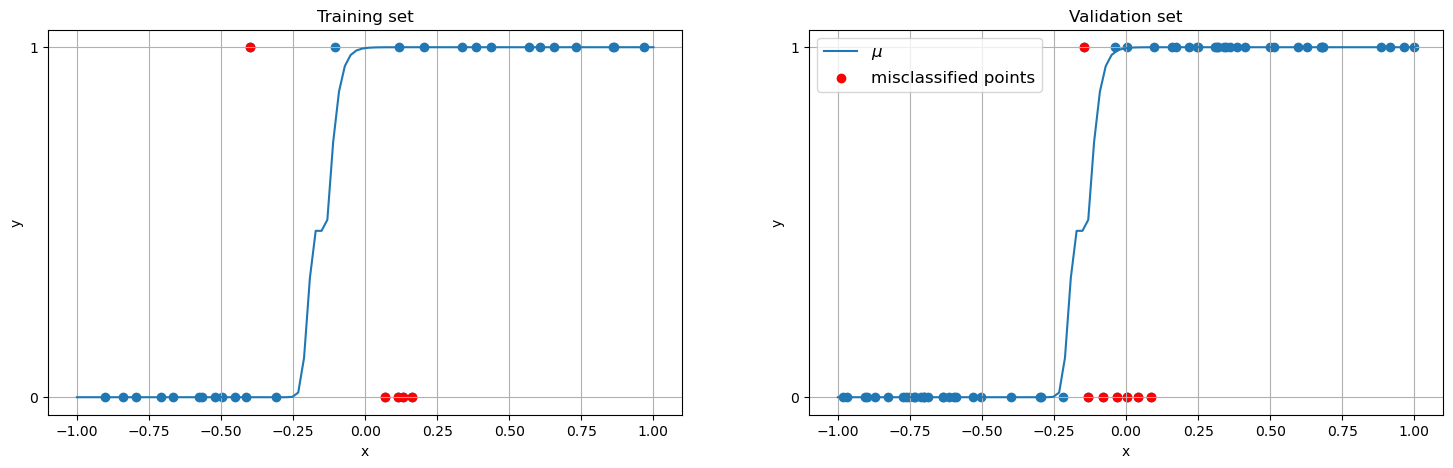

In [66]:
# Computing f_wb(x)
x_arr = np.linspace(-1,1,100)
x_ts = torch.tensor(x_arr, dtype=torch.float32).reshape(len(x_arr),1)
lin_out = model(x_ts)
f_wb =  F.sigmoid(lin_out).detach().numpy().reshape(len(x_arr))
# Computing misclassified points
Xtr_ts = torch.tensor(X_train,dtype = torch.float32); Xval_ts = torch.tensor(X_valid,dtype = torch.float32)
lin_tr = model(Xtr_ts); lin_val = model(Xval_ts) # wx + b
hwb_tr = torch.where(lin_tr >= 0, 1, 0).detach().numpy() # classifier h_wb
hwb_val= torch.where(lin_val >= 0, 1, 0).detach().numpy() 
ytr_flat = y_train.reshape(n_train); yval_flat = y_valid.reshape(n_valid); # Flattening vectors 
x_train = X_train.reshape(n_train); x_valid = X_valid.reshape(n_valid)
misclas_tr = [[x_train[i],ytr_flat[i]] for i in range(n_train) if ytr_flat[i] != hwb_tr[i]] 
misclas_val = [[x_valid[i],yval_flat[i]] for i in range(n_valid) if yval_flat[i] != hwb_val[i]]
misclas_tr = np.array(misclas_tr).transpose(); misclas_val = np.array(misclas_val).transpose()
#Plotting
fig, ax = plt.subplots(1,2,figsize = (18,5))
ax[0].set_yticks([0,1]); ax[1].set_yticks([0,1])
ax[0].set_xlabel('x'); ax[1].set_xlabel('x')
ax[0].set_ylabel('y'); ax[1].set_ylabel('y')
ax[0].plot(x_arr,f_wb); ax[1].plot(x_arr,f_wb, label = r'$\mu$')
ax[0].scatter(X_train.reshape(n_train),y_train.reshape(n_train))
ax[1].scatter(X_valid.reshape(n_valid),y_valid.reshape(n_valid))
if len(misclas_tr) > 0:
    ax[0].scatter(misclas_tr[0],misclas_tr[1],color = 'red')
if len(misclas_val) > 0:
    ax[1].scatter(misclas_val[0],misclas_val[1],color = 'red', label = 'misclassified points')
ax[0].set_title('Training set'); ax[1].set_title('Validation set') 
ax[1].legend(fontsize = 12)
ax[0].grid(), ax[1].grid()
plt.show()

Adapting the computation of the PAC-Bayes error for the new architecture:

In [67]:
def KL_gauss_NN(prior,posterior):
    mu1_par = posterior.mu1.state_dict()
    mu1_0_par = prior.mu1.state_dict()
    t1_par = posterior.t1.state_dict()
    t1_0_par = prior.t1.state_dict()
    mu2_par = posterior.mu2.state_dict()
    mu2_0_par = prior.mu2.state_dict()
    t2_par = posterior.t2.state_dict()
    t2_0_par = prior.t2.state_dict()
    mu3_par = posterior.mu3.state_dict()
    mu3_0_par = prior.mu3.state_dict()
    t3_par = posterior.t3.state_dict()
    t3_0_par = prior.t3.state_dict()
    # Loop over parameters sets (weight matrices or bias matrices) of all layers
    KL1 = 0
    for mu, mu_0, t, t_0 in zip(mu1_par.values(), mu1_0_par.values(), t1_par.values(), t1_0_par.values()):
        s = - torch.log(F.sigmoid(t))
        s_0 = - torch.log(F.sigmoid(t_0))
        KL_batch = 0.5*(torch.log(s_0/s) + (mu - mu_0)**2/s_0 + s/s_0 - 1) # KL divergence of parameter set 
        KL1 += KL_batch.sum()
    KL2 = 0
    for mu, mu_0, t, t_0 in zip(mu2_par.values(), mu2_0_par.values(), t2_par.values(), t2_0_par.values()):
        s = - torch.log(F.sigmoid(t))
        s_0 = - torch.log(F.sigmoid(t_0))
        KL_batch = 0.5*(torch.log(s_0/s) + (mu - mu_0)**2/s_0 + s/s_0 - 1) # KL divergence of parameter set 
        KL2 += KL_batch.sum()
    KL3 = 0
    for mu, mu_0, t, t_0 in zip(mu3_par.values(), mu3_0_par.values(), t3_par.values(), t3_0_par.values()):
        s = - torch.log(F.sigmoid(t))
        s_0 = - torch.log(F.sigmoid(t_0))
        KL_batch = 0.5*(torch.log(s_0/s) + (mu - mu_0)**3/s_0 + s/s_0 - 1) # KL divergence of parameter set 
        KL3 += KL_batch.sum()
    return KL1 + KL2 + KL3

def term_3_NN(prior, posterior, delta, n):
    KL = KL_gauss_NN(prior,posterior)
    return torch.sqrt((KL + log(2*sqrt(n)/delta))/n)

def term_2(deltap, m):
    return sqrt(log(2/deltap)/m)

def emp_error(posterior, m, X, y):
    '''
    Average misclassification error for m samples of posterior
    '''
    acc = 0
    for _ in range(m):
        yhat = torch.where(posterior(X) >= 0 , 1, 0)
        accuracy = Accuracy(task="binary")
        acc += accuracy(yhat, y)
    acc = acc / m
    mis_err = 1 - acc
    return mis_err

def give_PAC_Bayes_error_NN(prior, posterior, m, n, delta, deltap, X, y):
    return emp_error(posterior, m, X, y) + term_2(deltap, m) + term_3_NN(prior, posterior, delta, n)

In [68]:
prior_nn = Prob_NNModel(s_0 = 0.5, M = 1000)
prior_nn.mu1.load_state_dict(prior_nn_mu.lin1.state_dict())
prior_nn.mu2.load_state_dict(prior_nn_mu.lin2.state_dict())
prior_nn.mu3.load_state_dict(prior_nn_mu.lin3.state_dict())

<All keys matched successfully>

In [69]:
delta = 0.001; deltap = 0.05;
m = 100; n = n_valid;
X = torch.tensor(X_valid,dtype=torch.float32); y = torch.tensor(y_valid,dtype=torch.float32)

PB_err = give_PAC_Bayes_error_NN(prior_nn, model_probnn1, m, n, delta, deltap, X, y)
emp_err = emp_error( model_probnn1, m, X, y)
print('Empirical misclassification error: ', emp_err.item(), '\nPAC-Bayes error: ',  PB_err.item())

Empirical misclassification error:  0.1396666169166565 
PAC-Bayes error:  11.760255813598633


In this case, the PAC-Bayes error is vacuous. This is not surprising since we deliberately set the neural network to be much bigger than is appropriate for  the number of data-points. 

Finally, we plot a histogram of the values for the standard deviation `s` of the probabilistic neural network.

In [70]:
# t values
w1 = torch.flatten(model_probnn1.t1.weight)
w2 = torch.flatten(model_probnn1.t2.weight)
w3 = torch.flatten(model_probnn1.t3.weight)
b1 = torch.flatten(model_probnn1.t1.bias)
b2 = torch.flatten(model_probnn1.t2.bias)
b3 = torch.flatten(model_probnn1.t3.bias)

In [71]:
w_t = torch.cat((w1,w2,w3))
b_t = torch.cat((b1,b2,b3))
w = - torch.log(torch.sigmoid(w_t)).detach().numpy()
b = - torch.log(torch.sigmoid(b_t)).detach().numpy()

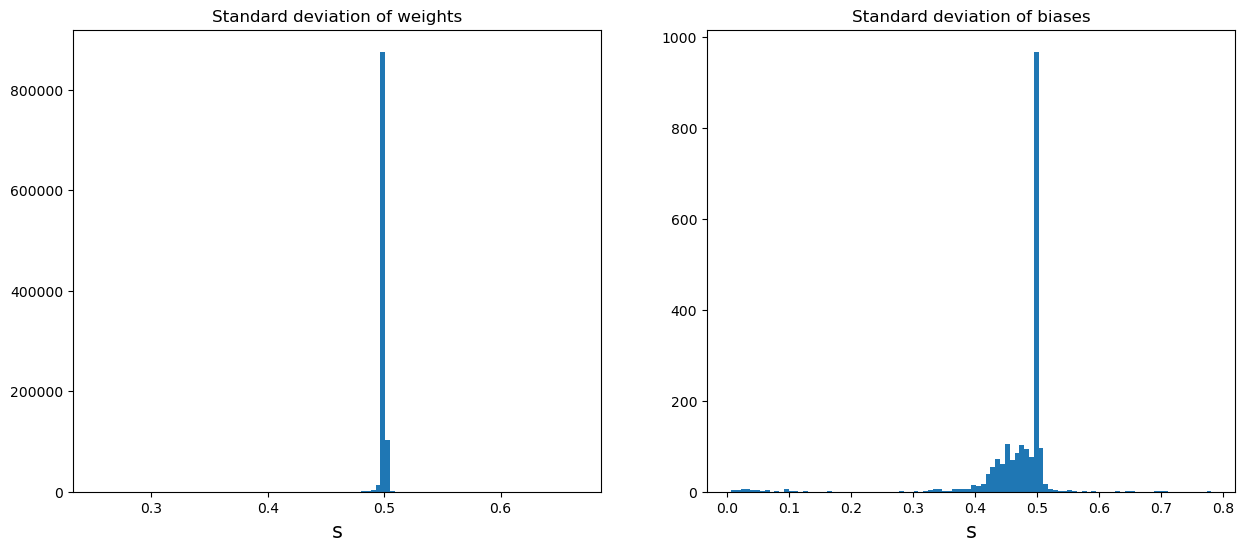

In [72]:
fig, ax = plt.subplots(1,2, figsize = (15,6))
ax[0].hist(w,bins =100)
ax[1].hist(b,bins = 100)
ax[0].set_xlabel('s',fontsize =15); ax[1].set_xlabel('s',fontsize =15)
ax[0].set_title('Standard deviation of weights'); ax[1].set_title('Standard deviation of biases');
plt.show()

We can see that the both the weights and biases have sharp peaks around the initialised value $s =\tfrac{1}{2}$.
This is not surprising since we only trained for 20 epochs.

Interestingly, the standard deviation of the biases decreased a lot more than the weights, 
indicating that the network is more certain of the biases.
